# Practice 5: Ligand classification model

> **Note:** This book is available in two ways:
> 1. Downloading the repository and following the instructions in the file [README.md](https://github.com/ramirezlab/CHEMO/blob/main/README.md)
> 2. Clicking here on [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ramirezlab/PILE/blob/main/3.%20Machine%20learning%3A%20teor%C3%ADa%20y%20aplicaciones%20en%20el%20dise%C3%B1o%20de%20f%C3%A1rmacos/3.2_Practice-1.en.ipynb?hl=es)


## Introduction
Machine learning has established itself as an essential component in data science, enabling computers to learn from data and make decisions or predictions without being cleanly programmed to do so. Within this framework, an algorithm of particular importance is the *RandomForest* classification model.

<img src="./img/random_forest.png" width="600" align='right'>

The RandomForest model is a supervised learning algorithm that is based on the ensemble method. This method combines several weaker algorithms to form a more powerful and robust model. In the case of RandomForest, a "forest" of *decision trees* is created, each perturbing on a random subset of the data <sup> **1** </sup>. The end result is the combination of the predictions from all these individual trees.

RandomForest is characterized by being versatile and efficient, capable of handling a large number of features and addressing both classification and regression problems. One of the advantages of this algorithm is that it provides a measure of the importance of the variables, offering valuable information about the model and the data.

### Validation Strategy: K-fold Cross Validation

Model validation is a crucial step in the development of any machine learning algorithm. Its purpose is to evaluate how well the learned model can generalize to unseen data, that is, it was not used during the training phase. In our practice, we will employ the K-Fold cross-validation strategy.

<img src="./img/K-fold_Cross_Validation.png" width="500" align='left'>

K-Fold cross validation is a powerful and widely used technique that improves model performance estimation. Instead of dividing the data set once into a training set and a test set, K-Fold cross-validation divides the data set into 'K' distinct subsets. The algorithm is then trained 'K' times, each time using a different subset as the test set and the rest of the subsets as the training set. Finally, the performance of the model is averaged over the 'K' iterations to obtain a more robust estimate <sup> **2** </sup>.

The goal is to test the model's ability to predict previously unseen data, detect problems such as overfitting, and assess the generalizability of the model.


### Performance measures

The choice of performance measures depends on the nature of the problem being addressed. However, there are some common measures that are often useful in evaluating the performance of classification models. To understand and calculate these performance measures, it helps to know their formulas. Before providing the formulas, it is important to note that they are based on the concepts of True Positives (**TP**), False Positives (**FP**), True Negatives (**TN**), and False Negatives (**FN**), which are the four possible categories into which the predictions of our model can be classified. The confusion matrix is useful to differentiate each concept <sup> **3** </sup>:

<img src="./img/confusion_matrix.png" width="400">

* **Accuracy**: It is the proportion of correct predictions among the total number of predictions made. Although it is an intuitive and easy to understand measure, the accuracy can be misleading if the classes are unbalanced. Accuracy is calculated as the sum of the correct predictions (both positive and negative) divided by the total predictions.
    $$Accuracy = \dfrac{TP + TN}{TP + TN + FP + FN}$$

* **Precision (Precision)**: It is the proportion of positive predictions that were correct. It is a useful measure when false positives are of particular concern. Precision is calculated as the number of true positives divided by the sum of true positives and false positives.
    $$Precision = \dfrac{TP}{TP+FP}$$

* **Recall (Sensitivity)**: It is the proportion of real positive cases that the model correctly identified. It is important when false negatives are a concern. The recall is calculated as the number of true positives divided by the sum of true positives and false negatives.
    $$Remember = \dfrac{TP}{TP + FN}$$

* **F1 Score (F1 Score)**: It is the harmonic mean of precision and recall. This measure seeks a balance between precision and recall. The F1 score is calculated as the harmonic average of precision and recall.
    $$F1_{score} = 2 \times \dfrac{Precision \times Recall}{Precision + Recall}$$

* **ROC curve (Receiver Operating Characteristic)** <sup> **3** </sup>: This curve is a graphical representation that illustrates the discriminative capacity of a binary classifier as its discrimination threshold varies. It is created by plotting the true positive rate (Recall) against the false positive rate (1-Specificity), at various threshold levels. A model with perfect predictive power would be located in the upper left corner of the graph, while a random model would follow the diagonal line.

* **AUC (Area Under the Curve)**: This metric is calculated as the area under the ROC curve. An AUC of 1.0 denotes a perfect pattern, while an AUC of 0.5 denotes a pattern that has no discriminatory ability, equivalent to a random selection. The higher the AUC, the better the model will be at distinguishing between the positive and negative classes.

In our analysis of the implementation of the RandomForest model, we will use these measures to assess its performance and generalizability.

# Data preparation
We start by importing the data from the previous lab, as these are stored in the folder of the second part, we can create a `root directory` (`ROOT_DIR`) to navigate to the file and load it into a dataframe

## Data loading

In [ ]:
# The Pandas library is imported with the alias 'pd'
import pandas as pd

# The 'os' module is imported for file system operations
import os

# 'Path' is imported from the 'pathlib' library to work with file paths more flexibly
from pathlib import Path

# The 'requests' library is imported to perform HTTP requests
import requests

# Define the UniProt ID and the URL of the CSV file
uniprot_id = 'P49841'
csv_url = 'https://raw.githubusercontent.com/ramirezlab/PILE/refs/heads/main/2.%20De%20datos%20a%20gr%C3%A1ficas%3A%20Propiedades%20drug-likeness%20y%20similitud%20qu%C3%ADmica%20con%20python/data/compounds_P49841_lipinski.csv'

# Read the CSV file from the URL and load it into a DataFrame
df_output = pd.read_csv(csv_url)

# Display the first rows of the DataFrame
df_output.head()


In this exercise we only need the ligands that comply with the *rule of five*, therefore, we must filter by the column: `rule_of_five_conform:yes`. Also, we only need the first three columns

In [ ]:
# Print the total number of ligands in the original DataFrame
print(f'# lignados totales: {len(df_output)}')

# Filter the DataFrame to keep only ligands that comply with Lipinski's rule (rule_of_five_conform == 'yes')
df_output = df_output[df_output['rule_of_five_conform']=='yes']

# Select only the relevant columns: ligand ID, pChEMBL value, and SMILES string
df_output = df_output[['molecule_chembl_id', 'pchembl_value', 'smiles']]

# Print the number of ligands that comply with Lipinski's rule
print(f'# ligandos filtrados (rule_of_five_conform:yes): {len(df_output)}')

# Display the first rows of the filtered DataFrame
df_output.head()

## Data processing
### Molecular Fingerprints

To train our algorithm, it is necessary to convert the ligands into a list of features. Currently, we have the molecular structure (SMILES) of each ligand, and with this information we can generate an alternative representation known as *fingerprint*. This representation will be used later to train the model.

To identify and generate the fingerprints of each ligand, we will use the `rdkit` library. This operation will result in the creation of a new column in our data set that will contain the fingerprint of each ligand. There are several types of fingerprints, but this time we will work with the [Extended Connectivity Fingerprint ECFP](https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md) also known as morgan2_c/ecfp4 <sup> **4** </sup>.

In [ ]:
# Install the RDKit library (if not already installed)
!pip install rdkit

# Import the 'Chem' module from RDKit to manipulate molecules
from rdkit import Chem

# Import the 'rdMolDescriptors' module from RDKit to generate molecular descriptors
from rdkit.Chem import rdMolDescriptors

# Create a copy of the original DataFrame to work with fingerprints
df_fp = df_output.copy()

# Compute the Morgan fingerprint (radius 2) for each molecule from its SMILES string
# 'Chem.MolFromSmiles(smile)' converts the SMILES string into a Mol object
# 'GetMorganFingerprintAsBitVect(..., 2)' generates the fingerprint as a binary vector
# 'ToList()' converts the fingerprint to a list of integers (0s and 1s)
df_fp['morgan2_c'] = df_output.smiles.map(lambda smile: rdMolDescriptors.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), 2).ToList())

# Select only the relevant columns: ligand ID, Morgan fingerprint, and pChEMBL value
df_fp = df_fp[['molecule_chembl_id', 'morgan2_c', 'pchembl_value']]

# Display the first rows of the DataFrame with fingerprints
df_fp.head()

Let's explore the first fingerprint: a binary list (ones and zeros) with a length of 2048 elements. These fingerprint elements will be the features that will be used to train the model.

In [ ]:
# Print the Morgan fingerprint (as a list of 0s and 1s) corresponding to the first ligand in the DataFrame
print(df_fp.morgan2_c[0])

# Print the length of the first ligand's fingerprint (total number of bits in the vector)
print(len(df_fp.morgan2_c[0]))

### Classification of ligands

Each ligand must be classified as **active** or **inactive**, for this we will use the `pchembl_value` column defining activity thresholds
The protein *Glycogen synthase kinase-3 beta* is classified in the group of *Kinases*, therefore, we will use the following thresholds:

**Inactive**: *pchembl_value* < 6.52 uM

**Active**: *pchembl_value* >= 7.52 uM

In [ ]:
# Add a new column called 'activity_type' with default value 'Intermediate'
df_fp['activity_type'] = 'Intermediate'

# Mark as 'Active' those molecules with a pChEMBL value greater than or equal to 7.5
df_fp.loc[df_fp[df_fp.pchembl_value >= 7.5].index, 'activity_type'] = 'Active'

# Mark as 'Inactive' those molecules with a pChEMBL value less than 6.52
df_fp.loc[df_fp[df_fp.pchembl_value < 6.52].index, 'activity_type'] = 'Inactive'

# Display the first rows of the updated DataFrame
df_fp.head()

Let's see graphically how the classification was

In [ ]:
# Print the number of molecules classified in each activity category (Active, Intermediate, Inactive)
print(df_fp.activity_type.value_counts())

# Generate a bar plot showing the distribution of molecules by activity type
df_fp.activity_type.value_counts().plot.bar(x='activity_type')

Now we filter the data removing those that are classified as *Intermediate*

In [ ]:
# A new DataFrame 'bd' is created containing only the molecules classified as 'Active' or 'Inactive'
# Molecules labeled as 'Intermediate' are excluded, and a copy of the subset is made
bd = df_fp[df_fp['activity_type'] != 'Intermediate'].copy()

# A bar plot is generated showing the number of active and inactive ligands
bd.activity_type.value_counts().plot.bar(x='activity_type')

# Print the total number of ligands in the new DataFrame (only active and inactive)
print(f'# ligandos (active/inactive): {len(bd)}')

# Print the count of ligands by activity category (Active, Inactive)
print(bd.activity_type.value_counts())

# Display the first rows of the 'bd' DataFrame
bd.head()

Since it is a binary classification, we must assign a label: (Inactive:0 / Active:1)

In [ ]:
# A new column called 'activity' is added and initialized with value 0 (by default all molecules are inactive)
bd['activity'] = 0

# The value 1.0 is assigned in the 'activity' column to molecules classified as 'Active'
bd.loc[bd[bd.activity_type == 'Active'].index, 'activity'] = 1.0

# The columns 'activity_type' and 'pchembl_value' are removed from the DataFrame, as they will not be used in the model
bd.drop(['activity_type', 'pchembl_value'], axis=1, inplace=True)

# Display the first rows of the updated DataFrame
bd.head()

We already have the features (morgan2_c fingerprint) and tags (activity) to be able to train the model

# Train the model with the *Random Forest* algorithm

We are going to train a Random Forest model that classifies ligands knowing the fingerprint. The goal is to test the model's ability to predict data that has never been seen before, to detect problems known as overfitting, and to assess the generalizability of the model.

### Random Forest
Usually, the first step is to **split** the data set, one part for training (70%) and the other part for testing (30%).

In [ ]:
# The 'train_test_split' function is imported from the 'model_selection' module of scikit-learn
from sklearn.model_selection import train_test_split

# The 'bd' DataFrame is split into training and test sets
# 'test_size=0.3' indicates that 30% of the data will be used for testing
# 'random_state=142857' ensures the reproducibility of the split
# 'shuffle=True' shuffles the data randomly before splitting
# 'stratify=bd['activity']' ensures that the class proportions (0 and 1) are preserved in both sets
fp_df_train, fp_df_test = train_test_split(bd, test_size=0.3, random_state=142857,
                                            shuffle=True, stratify=bd['activity'])

# The indices of the training and test DataFrames are reset to avoid duplicates or disordered indices
fp_df_train.reset_index(drop=True, inplace=True)
fp_df_test.reset_index(drop=True, inplace=True)

# The number of samples in the training and test sets is printed
print(f'# datos entrenamiento: {len(fp_df_train)},'
      f'\n# datos prueba: {len(fp_df_test)}')

Now, for each set we are going to separate the characteristics (the fingerprint) and the label

In [ ]:
# The input variables (X) and the target variable (y) are separated for the training set
X_train, y_train = fp_df_train.morgan2_c, fp_df_train.activity

# The input variables (X) and the target variable (y) are separated for the test set
X_test, y_test = fp_df_test.morgan2_c, fp_df_test.activity

# The feature vectors are converted to lists of elements for use with scikit-learn models
X_train, X_test = X_train.tolist(), X_test.tolist()

We choose the estimator of [Random Fores classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to train the model, the model must be instantiated and built

In [ ]:
# The 'RandomForestClassifier' class is imported from the 'ensemble' module of scikit-learn
from sklearn.ensemble import RandomForestClassifier

# An instance of the Random Forest classification model is created
model = RandomForestClassifier()

# The model is trained using the training data
model.fit(X_train, y_train)

## Validation
### Accuracy score

There are several metrics to measure the ability of the model to make predictions, let's see an example using the metric [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html?highlight=accuracy_score#sklearn.metrics.accuracy_score)

The first thing is to classify (*predict*) the data from the set and then compare it with the true labels, we will do this with both the **training set** and the **test set**:

In [ ]:
# The 'accuracy_score' function is imported from the 'metrics' module of scikit-learn
from sklearn.metrics import accuracy_score

# The model's prediction is performed on the training set
y_train_pred = model.predict(X_train)

# The model's prediction is performed on the test (validation) set
y_test_pre = model.predict(X_test)

# Accuracy is calculated for the training set
acc_train = accuracy_score(y_train, y_train_pred)

# Accuracy is calculated for the test set
acc_test = accuracy_score(y_test, y_test_pre)

# Accuracy scores are printed with 4 decimal places and as percentages
print(f'Accuracy conjunto de entrenamiento: {acc_train:.4f} ({acc_train:.2%})\n'
      f'Accuracy conjunto de prueba: {acc_test:.4f} ({acc_test:.2%})')

The *accuracy* of the training set is 100%, which indicates a case of *Overfitting*, it may be necessary to adjust the parameters of the classification model or even use another model.

### Confusion Matrix
With this matrix you can compare the true labels versus the model predictions, [here](https://en.wikipedia.org/wiki/Confusion_matrix) you can see more information about the confusion matrix. In this case we are going to compare the data from the validation set:

In [ ]:
# The 'ConfusionMatrixDisplay' class is imported from scikit-learn's 'metrics' module to visualize confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay

# The Matplotlib library is imported for visualization
import matplotlib.pyplot as plt

# The confusion matrix is generated and displayed based on the test set predictions
# 'colorbar=False' disables the color bar
# 'cmap=plt.cm.Blues' sets a blue color palette for the visualization
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,  cmap=plt.cm.Blues)

You can work with the normalized data to see it as a percentage

In [ ]:
# The normalized confusion matrix is generated and displayed based on the test set predictions
# 'colorbar=False' disables the color bar
# 'cmap=plt.cm.Blues' sets a blue-toned color palette
# 'normalize="true"' normalizes the matrix by row, showing proportions instead of absolute counts
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,
                                        cmap=plt.cm.Blues, normalize='true')

### ROC curve
The ROC curve (ROC curve, Receiver Operating Characteristic) is a graphical representation of the sensitivity versus the specificity for a binary classifier system as the discrimination threshold is varied, it is usually used to represent how good the model is, let's see how you can build one:

In [ ]:
# The 'roc_curve' and 'auc' functions are imported from scikit-learn's 'metrics' module to evaluate model performance
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Matplotlib libraries are imported for visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# The predicted probabilities for the positive class (1) are obtained from the training set
pred_prob_train = model.predict_proba(X_train)[:, 1]

# The predicted probabilities for the positive class (1) are obtained from the test set
pred_prob_test = model.predict_proba(X_test)[:, 1]

# False positive rates (FPR) and true positive rates (TPR) are calculated for the training set
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
# The area under the curve (AUC) is calculated for the training set
roc_auc_train = auc(fpr_train, tpr_train)

# False positive rates (FPR) and true positive rates (TPR) are calculated for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
# The area under the curve (AUC) is calculated for the test set
roc_auc_test = auc(fpr_test, tpr_test)

# A figure is created to plot the ROC curves
plt.figure(figsize=(7, 7))

# The ROC curve for the training set is plotted
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)

# The ROC curve for the test set is plotted
plt.plot(fpr_test, tpr_test, label=f'AUC test = {roc_auc_test:.2f}', lw=2)

# A diagonal line is plotted as a reference for a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve

# Axis labels and title are configured
plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('Random forest ROC curves', size=24)

# Axis tick label size is adjusted
plt.tick_params(labelsize=16)

# The plot legend is displayed
plt.legend(fontsize=16)


### K-fold (cross validation)

We are going to divide the data into 5 sets, each one of them will train the algorithm and measure its predictive capacity, then the data from the five models will be contrasted to validate if the trained model works or not.

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

n_folds = 5
# Empty list to store results
results = []

# Shuffle indices for k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True)

# Labels initialized to -1 for each data point
labels = -1 * np.ones(len(bd))

# Model instance
model = RandomForestClassifier()

for train_index, test_index in kf.split(bd):
    # Training
    # Convert binary vectors and labels to lists
    train_x = bd.iloc[train_index].morgan2_c.tolist()
    train_y = bd.iloc[train_index].activity.tolist()

    # Fit the model with the training data
    model.fit(train_x, train_y)

    # Testing
    # Convert binary vectors and labels to lists
    test_x = bd.iloc[test_index].morgan2_c.tolist()
    test_y = bd.iloc[test_index].activity.tolist()

    # Predict probabilities on the test set
    prediction_prob = model.predict_proba(test_x)[:, 1]

    # Store the predicted label for each fold
    labels[test_index] = model.predict(test_x)

    # Evaluation
    # Get FPR, TPR, and AUC for each fold
    fpr_l, tpr_l, _ = roc_curve(test_y, prediction_prob)
    roc_auc_l = auc(fpr_l, tpr_l)

    # Add fold results to the list
    results.append((fpr_l, tpr_l, roc_auc_l))

# Compute overall metrics: accuracy, sensitivity, and specificity
y = bd.activity.tolist()
acc = accuracy_score(y, labels)
sens = recall_score(y, labels)
spec = (acc * len(y) - sens * sum(y)) / (len(y) - sum(y))


In [ ]:
# A figure is created for plotting with size 7x7 inches
plt.figure(figsize=(7, 7))

# A blue color map is retrieved from Matplotlib
cmap = mpl.colormaps['Blues']

# A list of colors is generated from the color map, spaced evenly according to the number of folds
colors = [cmap(i) for i in np.linspace(0.1, 1.0, n_folds)]

# The list of results from cross-validation is iterated over
for i, (fpr_l, tpr_l, roc_auc_l) in enumerate(results):
    # The ROC curve for each fold is plotted with its respective AUC
    plt.plot(fpr_l, tpr_l, label='AUC CV$_{0}$ = {1:0.2f}'.format(str(i), roc_auc_l), lw=2, color=colors[i])
    # The x-axis limits are defined
    plt.xlim([-0.05, 1.05])
    # The y-axis limits are defined
    plt.ylim([-0.05, 1.05])

# A diagonal line is plotted to represent a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve

# The x-axis label is set
plt.xlabel('False positive rate', size=24)

# The y-axis label is set
plt.ylabel('True positive rate', size=24)

# The title of the plot is set
plt.title(f'Random forest ROC curves', size=24)

# The size of axis tick labels is adjusted
plt.tick_params(labelsize=16)

# The plot legend is displayed
plt.legend(fontsize=16)

# The plot is displayed on screen
plt.show()


In [ ]:
# Calculate the mean AUC from the fold results and print it
m_auc = np.mean([elem[2] for elem in results])
print(f'Mean AUC: {m_auc:.3f}')

# Display overall metrics: sensitivity, accuracy, and specificity
print(f'Sensitivity: {sens:.3f}\nAccuracy: {acc:.3f}\nSpecificity: {spec:.3f}')

## Conclusions
The Random Forest classification algorithm is exceptionally powerful for performing binary classifications. In the case of our study, this involved classifying molecules as active or inactive. However, our initial implementation of the model revealed a significant overfitting of the data. This phenomenon suggests that the algorithm tries to capture all the characteristics of the molecules instead of achieving an effective generalization. Overfitting can lead to low predictability for molecules that are not part of the training set, a scenario we would prefer to avoid.

## Practice Activity
To decrease the overfitting problem, you can change the [model parameters](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier), which regulate how the training is carried out. As a practical activity, you are invited to experiment with the modification of these parameters and to compare the results obtained. Can you find a set of parameters that will reduce overfitting and improve the overall performance of the model? How do these changes affect different performance metrics? Explore and share your findings.

# Machine Learning XGBoost

An alternative to the overfitting problem is to explore the use of a different classification model to train our algorithm. This time, we decided to implement XGBoost, an efficient and sophisticated machine learning software library based on the decision tree boosting algorithm <sup> **5** </sup>.

XGBoost, which stands for eXtreme Gradient Boosting, is known for its speed and performance. It is an algorithm that has proven valuable in a variety of data science competitions and has been widely adopted in the industry. As a boosting algorithm, XGBoost is based on the idea of creating a strong predictive model by combining a series of weaker models, iteratively improving the predictions of the ensemble.

## Model training

In this practice we are going to train a model with some parameters established in advance, which improve the default model.

In [19]:
# The XGBoost library is imported and assigned the alias 'xgb'
import xgboost as xgb

# An instance of the XGBoost classifier is created
xgbc_model = xgb.XGBClassifier()

# Training parameters
params = {
    'objective': 'binary:logistic',              # Type of problem: binary classification
    'early_stopping_rounds': 20,                 # Stop training if no improvement after 20 rounds
    'enable_categorical': False,                 # Disable automatic handling of categorical variables
    'eval_metric': ['error', 'auc'],             # Evaluation metrics: classification error and AUC
    'gamma': 0.2,                                # Minimum loss reduction required to make a split
    'grow_policy': 'depthwise',                  # Tree growth strategy (by depth)
    'learning_rate': 0.32,                       # Learning rate
    'max_depth': 7,                              # Maximum tree depth
    'min_child_weight': 1,                       # Minimum sum of instance weight (hessian) needed in a child
    'n_estimators': 100,                         # Number of trees (estimators)
    'scale_pos_weight': 3.271,                   # Weight for positive class (useful for class imbalance)
    'subsample': 0.8,                            # Fraction of data used for each tree
    'alpha': 0.2,                                # L1 regularization term
    'lambda': 1.4                                # L2 regularization term
}

# The defined parameters are assigned to the XGBoost model
xgbc_model.set_params(**params)


XGBClassifier(alpha=0.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['error', 'auc'],
              feature_types=None, gamma=0.2, gpu_id=None,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=1.4, learning_rate=0.32,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

To train the XGBoost model it is necessary to generate a validation set to use the "early stopping" functionality of XGBoost. "Early stopping" is a way to prevent model overfitting by stopping training when the validation error stops improving.

Thus, our initial set `X_train, y_train` is divided into two: `X_temp, y_temp` and `X_valid, y_valid` with a ratio of 80:20.

Then we can train the model:

In [20]:
# The original training set is split into a new training set (X_temp, y_temp)
# and a validation set (X_valid, y_valid)
# 'test_size=0.2' indicates that 20% of the data will be used for validation
# 'random_state=42' ensures reproducibility of the split
X_temp, X_valid, y_temp, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# The XGBoost model is trained using the new training set
# and evaluated on the provided validation set via 'eval_set'
xgbc_model.fit(X_temp, y_temp, eval_set=[(X_valid, y_valid)])

[0]	validation_0-error:0.25391	validation_0-auc:0.81419
[1]	validation_0-error:0.24219	validation_0-auc:0.85467
[2]	validation_0-error:0.26172	validation_0-auc:0.86577
[3]	validation_0-error:0.21484	validation_0-auc:0.88078
[4]	validation_0-error:0.20312	validation_0-auc:0.89604
[5]	validation_0-error:0.20703	validation_0-auc:0.90118
[6]	validation_0-error:0.19141	validation_0-auc:0.90669
[7]	validation_0-error:0.17578	validation_0-auc:0.90672
[8]	validation_0-error:0.17969	validation_0-auc:0.90967
[9]	validation_0-error:0.17578	validation_0-auc:0.91132
[10]	validation_0-error:0.17188	validation_0-auc:0.91301
[11]	validation_0-error:0.17578	validation_0-auc:0.91071
[12]	validation_0-error:0.15625	validation_0-auc:0.91315
[13]	validation_0-error:0.15625	validation_0-auc:0.91376
[14]	validation_0-error:0.15234	validation_0-auc:0.91464
[15]	validation_0-error:0.15625	validation_0-auc:0.91498
[16]	validation_0-error:0.16016	validation_0-auc:0.91457
[17]	validation_0-error:0.16406	validatio

XGBClassifier(alpha=0.2, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric=['error', 'auc'],
              feature_types=None, gamma=0.2, gpu_id=None,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints=None, lambda=1.4, learning_rate=0.32,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None, ...)

## Save and Load the Model

Once the model has been trained, it can be saved using the `save_model` command.

In [21]:
# Create the './data' directory if it doesn't exist (system command)
!mkdir -p ./data

# Save the trained XGBoost model in JSON format at the specified path
xgbc_model.save_model('data/P49841_model.json')

To load and use it, the `load_model()` command is used, for example:

In [22]:
# A new instance of the XGBoost classifier is created
new_model = xgb.XGBClassifier()

# The previously saved model is loaded from the JSON file
new_model.load_model('data/P49841_model.json')

## Validation of the model
With the model already trained as `xgbc_model`, we can now evaluate the performance metrics, for example the accuracy:

In [23]:
# XGBoost model prediction on the training set
y_train_pred = xgbc_model.predict(X_train)

# XGBoost model prediction on the test set
y_test_pre = xgbc_model.predict(X_test)

# Accuracy calculation for the training set
acc_train = accuracy_score(y_train, y_train_pred)

# Accuracy calculation for the test set
acc_test = accuracy_score(y_test, y_test_pre)

# Print accuracy results in decimal and percentage formats
print(f'Accuracy conjunto de entrenamiento: {acc_train:.4f} ({acc_train:.2%})\n'
      f'Accuracy conjunto de prueba: {acc_test:.4f} ({acc_test:.2%})')

Accuracy conjunto de entrenamiento: 0.9655 (96.55%)
Accuracy conjunto de prueba: 0.8960 (89.60%)


This result indicates that the overfitting has been decreased.

Let's look at the confusion matrix:

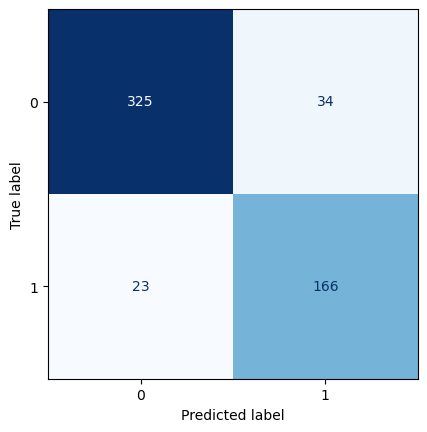

In [24]:
# Generate and display the confusion matrix for XGBoost model predictions on the test set
# 'colorbar=False' disables the color bar
# 'cmap=plt.cm.Blues' applies a blue color palette
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,  cmap=plt.cm.Blues)

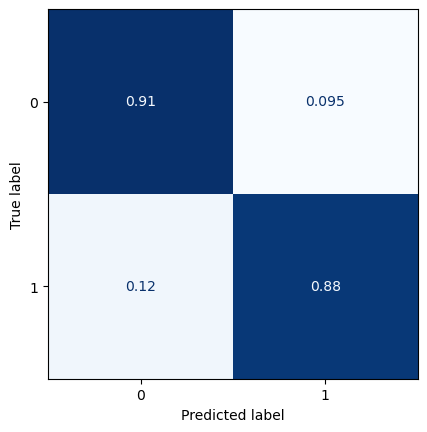

In [25]:
# Generate and display the normalized confusion matrix for XGBoost model predictions on the test set
# 'colorbar=False' disables the color bar
# 'cmap=plt.cm.Blues' applies a blue color palette
# 'normalize="true"' normalizes the matrix by row, showing proportions instead of absolute counts
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pre, colorbar=False,
                                        cmap=plt.cm.Blues, normalize='true')

The process can also be repeated to plot the ROC curve along with the AUC.

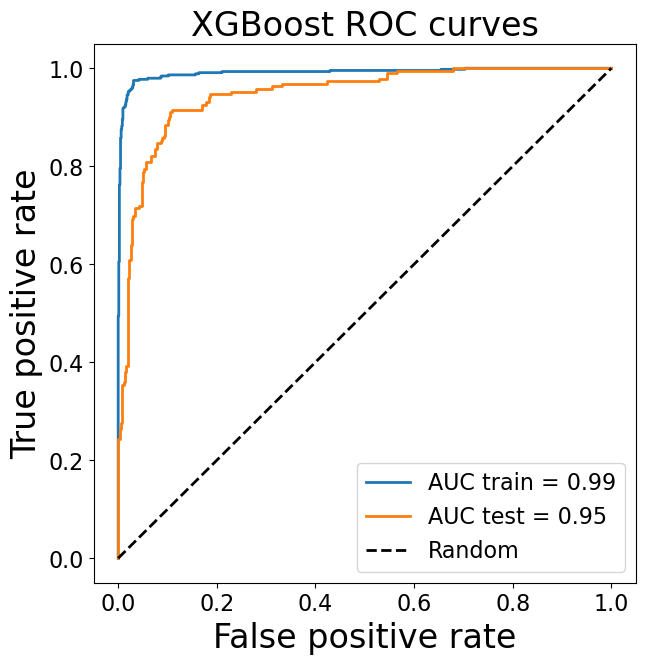

In [26]:
# Predicted probabilities for the positive class (1) in the training set
pred_prob_train = xgbc_model.predict_proba(X_train)[:, 1]

# Predicted probabilities for the positive class (1) in the test set
pred_prob_test = xgbc_model.predict_proba(X_test)[:, 1]

# Calculation of false positive rates (FPR) and true positive rates (TPR) for the training set
fpr_train, tpr_train, _ = roc_curve(y_train, pred_prob_train)
# Calculation of the area under the ROC curve (AUC) for the training set
roc_auc_train = auc(fpr_train, tpr_train)

# Calculation of false positive rates (FPR) and true positive rates (TPR) for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, pred_prob_test)
# Calculation of the area under the ROC curve (AUC) for the test set
roc_auc_test = auc(fpr_test, tpr_test)

# Create the figure to plot ROC curves
plt.figure(figsize=(7, 7))

# Plot the ROC curve for the training set
plt.plot(fpr_train, tpr_train, label=f'AUC train = {roc_auc_train:.2f}', lw=2)

# Plot the ROC curve for the test set
plt.plot(fpr_test, tpr_test, label=f'AUC test = {roc_auc_test:.2f}', lw=2)

# Diagonal line representing a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve

# Set axis labels and title
plt.xlabel('False positive rate', size=24)
plt.ylabel('True positive rate', size=24)
plt.title('XGBoost ROC curves', size=24)

# Adjust axis label font size
plt.tick_params(labelsize=16)

# Display the legend
plt.legend(fontsize=16)

# Practical Activity

Taking into account what was reviewed in this first part, make a code in python with which you can:

1. Randomly search for 10 compounds from the ChemBL database. You will need to calculate the smiles and determine if the compound is going to be active or not.

At the end, you must prepare a document in PDF format in which you attach the proposed code and the output of the execution.

# Conclusions
Throughout this practice, we work with two widely used classification algorithms: Random Forest and XGBoost. Each of these algorithms has its own advantages and limitations, and their performance can vary greatly depending on the type of data and parameter settings.

Our first approach was to employ the Random Forest algorithm using the default parameters. Although Random Forest is known for its ability to handle a wide range of classification problems, we found that in our case the resulting model suffered from overfitting. Overfitting is a common phenomenon in machine learning, where a model memorizes the features of the training set instead of learning to generalize from the underlying features. This limits the model's ability to make accurate predictions on unseen data.

To address this issue, we experimented with a second algorithm: XGBoost. XGBoost is a powerful and flexible algorithm that can be especially effective in addressing overfitting issues if configured correctly. For our XGBoost model, we defined an initial set of parameters and observed that after training and validating the model, the overfitting had decreased.

It's crucial to remember that there is no overall "best" or "worst" ranking algorithm. The effectiveness of an algorithm depends to a large extent on the data with which it works and how its parameters are configured. Therefore, the process of finding the most suitable classification algorithm for a given problem usually involves experimenting with different models and adjusting their parameters. Ultimately, the choice of algorithm and its configuration is a trade-off between model performance, interpretability, and computational efficiency.

As a continuation of this practice, it would be interesting to explore other classification models, as well as experiment with different parameter tuning techniques, such as grid search or Bayesian optimization, to further improve the performance of our classification model.

# References
1. Sarica, A., Cerasa, A., & Quattrone, A. (2017). Random forest algorithm for the classification of neuroimaging data in alzheimer’s disease: A systematic review. Frontiers in Aging Neuroscience, 9. https://www.frontiersin.org/articles/10.3389/fnagi.2017.00329
2. Refaeilzadeh, P., Tang, L., & Liu, H. (2009). Cross-validation. En L. LIU & M. T. ÖZSU (Eds.), Encyclopedia of Database Systems (pp. 532-538). Springer US. https://doi.org/10.1007/978-0-387-39940-9_565
3. Larrañaga, P., Calvo, B., Santana, R., Bielza, C., Galdiano, J., Inza, I., Lozano, J. A., Armañanzas, R., Santafé, G., Pérez, A., & Robles, V. (2006). Machine learning in bioinformatics. Briefings in Bioinformatics, 7(1), 86-112. https://doi.org/10.1093/bib/bbk007
4. Extended connectivity fingerprint ecfp | chemaxon docs. (s. f.). https://docs.chemaxon.com/display/docs/extended-connectivity-fingerprint-ecfp.md
5. Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794). New York, NY, USA: ACM. https://doi.org/10.1145/2939672.2939785